In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import json

In [2]:
data_root = Path('../data')

In [3]:
import re

def proc_string(string):
    b = re.split("(?<=(.))(?!\\1)",string)
    lens = [len(x) for i,x in enumerate(b) if i%2 == 0]
    chars = [x for i,x in enumerate(b) if i%2 != 0]
    
    return chars, lens[:-1]

# Lets start with *exact* MRC data used for the charCNN task

In [4]:
df = pd.read_csv('../data/dump/MRC/EnglishData-preprocessed_attempt_1.csv')
random_fold = pd.read_csv('folds/MRC_EnglishData_attempt_1_fold.csv')
subject_fold = pd.read_csv('folds/MRC_EnglishData_attempt_1_subject_lvl_fold.csv')
with open('../data/dump/MRC/char2idx.json', 'r') as json_file:
        char2idx = json.load(json_file)


In [5]:
random_fold_data = pd.merge(df,random_fold, how = 'inner',on = ['Patient_ID', 'Sentence_ID'])
subject_fold_data = pd.merge(df,subject_fold, how = 'inner',on = ['Patient_ID', 'Sentence_ID'])

In [6]:
# Find window dimensions and "key press duration" scaling factor
just_lengths = []
max_durations = []
for idx, row in df.iterrows():
    string = row['Preprocessed_typed_sentence']
    chars, lens = proc_string(string)
    just_lengths.append(len(chars))
    max_durations.append(max(lens))
H = np.max(just_lengths)
W = len(char2idx) + 1
scale_factor = np.max(max_durations)
print('Window height/width shoul be: {} / {}'.format(H,W))





Window height/width shoul be: 216 / 61


In [7]:
X = []
y = []
for idx, row in df.iterrows():
    string = row['Preprocessed_typed_sentence']
    chars, lens = proc_string(string)
    x = np.zeros((H,W))
    non0cols = [char2idx[c] for c  in chars]
    non0rows = np.arange(0,len(chars))
    x[non0rows,non0cols] = 1
    x[non0rows,-1] = np.asarray(lens) / scale_factor
    
    X.append(x)
    y.append(row['Diagnosis'])

X = np.asarray(X)
y = np.asarray(y)


# Super simple 1d conv network

In [19]:
from tensorflow.keras.layers import Conv1D, Input, Dense,Flatten, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [27]:
filters = 64
size_large = 5
size_small = 3
drop = 0.1
kernel_reg = tf.keras.regularizers.l2(0.05)
fc_reg = tf.keras.regularizers.l2(0.01)
lr= 0.5e-3

def mk_model(filters,size_large,size_small, drop, kernel_reg, fc_reg):
    inp = Input(shape = (H,W))
    c1 = Conv1D(filters = 64, kernel_size = size_large, strides = 1, activation = 'relu', kernel_regularizer= kernel_reg)(inp)
    c1 = Dropout(drop)(c1)
    c2 = Conv1D(filters = 64, kernel_size = size_small, strides = 1, activation = 'relu', kernel_regularizer= kernel_reg)(inp)
    c2 = Dropout(drop)(c2)
    flat = Flatten()(c2)
    out = Dense(2,activation = 'softmax', kernel_regularizer=fc_reg)(flat)

    return Model(inp,out)

model = mk_model(filters,size_large,size_small, drop, kernel_reg, fc_reg)

In [30]:
from tensorflow.keras import callbacks
import tensorflow as tf
import datetime

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, mode='auto', min_delta=0.0000, cooldown=0, min_lr=0)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience = 20, verbose = 1, restore_best_weights = True)
log_dir = Path("logs/MRC/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,)
callbacks = [reduce_lr, early_stopping, tensorboard_callback]

model.compile(optimizer = Adam(learning_rate = lr),loss ='sparse_categorical_crossentropy')

In [31]:
history = model.fit(x = x_train, y = y_train, batch_size = 128 , epochs = 1000, verbose = 0, validation_data = (x_test,y_test), callbacks = callbacks)


Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


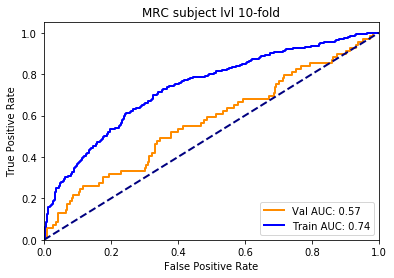

In [32]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

pred_t = model.predict(x_train)
pred = model.predict(x_test)
lw=2


fpr, tpr, _ = roc_curve(y_test, pred[:,1])
roc_auc = auc(fpr, tpr)



plt.plot(fpr, tpr , color = 'darkorange', lw=lw, label = 'Val AUC: {:.2f}'.format(roc_auc))

fpr, tpr, _ = roc_curve(y_train, pred_t[:,1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr , color = 'blue', lw=lw, label = 'Train AUC: {:.2f}'.format(roc_auc))

  
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MRC subject lvl 10-fold')
plt.legend(loc="lower right")
plt.show()

# Now that we have found suitable regularisation parameters lets do the 10 folds


note: Heavy regularisation in necessary to achieve good performance

## First random k-fold as in the paper


Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping

Epoch 00025: Reduce

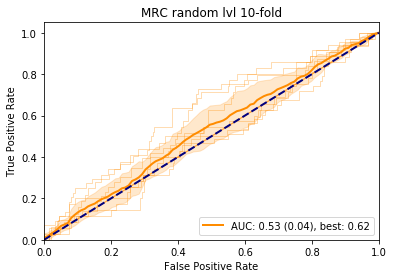

In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

lw = 2
plt.figure()
AUC = []
interp_tpr = []
lspace = np.linspace(0,1,100)



for fold in range(0,10):
    x_train = []
    x_test = []
    y_train = []
    y_test = []
    for idx, row in random_fold_data.iterrows():
        string = row['Preprocessed_typed_sentence']
        chars, lens = proc_string(string)
        x = np.zeros((H,W))
        non0cols = [char2idx[c] for c  in chars]
        non0rows = np.arange(0,len(chars))
        x[non0rows,non0cols] = 1
        x[non0rows,-1] = np.asarray(lens) / scale_factor
        lbl = row['Diagnosis']
        in_fold = row['fold']
        
        if in_fold == fold:
            x_test.append(x)
            y_test.append(lbl)
        else:
            x_train.append(x)
            y_train.append(lbl)

    x_train = np.asarray(x_train)
    x_test  = np.asarray(x_test)
    y_train = np.asarray(y_train)
    y_test  = np.asarray(y_test)
    
    
    #re init model
    model = mk_model(filters,size_large,size_small, drop, kernel_reg, fc_reg)
    callbacks = [reduce_lr, early_stopping]
    model.compile(optimizer = Adam(learning_rate = 1e-3),loss ='sparse_categorical_crossentropy')
    
    history = model.fit(x = x_train, y = y_train, batch_size = 16 , epochs = 1000, verbose = 0, validation_split = 0.1, callbacks = callbacks)
    
    pred = model.predict(x_test)
    
    fpr, tpr, _ = roc_curve(y_test, pred[:,1])
    interp_tpr.append(np.interp(lspace,xp=fpr,fp=tpr))
    roc_auc = auc(fpr, tpr)
    AUC.append(roc_auc)
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw -1, alpha = 0.3)
    
mean = np.mean(interp_tpr,axis=0)
std = np.std(interp_tpr,axis = 0)    
plt.plot(lspace, mean , color = 'darkorange', lw=lw, label = 'AUC: {:.2f} ({:.2f}), best: {:.2}'.format(np.mean(AUC),np.std(AUC),np.max(AUC)))
plt.fill_between(lspace,mean + std, mean - std, alpha = 0.2, color = 'darkorange')    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MRC random lvl 10-fold')
plt.legend(loc="lower right")
#plt.savefig('MJFF_subject_lvl_kfold.png')
plt.show()  

## Subject level k-fold


Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping

Epoch 00024: Reduce

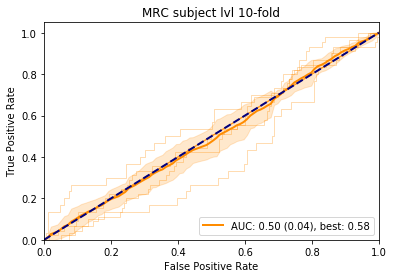

In [14]:
lw = 2
plt.figure()
AUC = []
interp_tpr = []
lspace = np.linspace(0,1,100)



for fold in range(0,10):
    x_train = []
    x_test = []
    y_train = []
    y_test = []
    for idx, row in subject_fold_data.iterrows(): # <<<<------ select fold here (to refactor into scipt at a later stage)
        string = row['Preprocessed_typed_sentence']
        chars, lens = proc_string(string)
        x = np.zeros((H,W))
        non0cols = [char2idx[c] for c  in chars]
        non0rows = np.arange(0,len(chars))
        x[non0rows,non0cols] = 1
        x[non0rows,-1] = np.asarray(lens) / scale_factor
        lbl = row['Diagnosis']
        in_fold = row['fold']
        
        if in_fold == fold:
            x_test.append(x)
            y_test.append(lbl)
        else:
            x_train.append(x)
            y_train.append(lbl)

    x_train = np.asarray(x_train)
    x_test  = np.asarray(x_test)
    y_train = np.asarray(y_train)
    y_test  = np.asarray(y_test)
    
    
    #re init model
    model = mk_model(filters,size_large,size_small, drop, kernel_reg, fc_reg)
    callbacks = [reduce_lr, early_stopping]
    model.compile(optimizer = Adam(learning_rate = 1e-2),loss ='sparse_categorical_crossentropy')
    
    history = model.fit(x = x_train, y = y_train, batch_size = 16 , epochs = 1000, verbose = 0, validation_split = 0.1, callbacks = callbacks)
    
    pred = model.predict(x_test)
    
    fpr, tpr, _ = roc_curve(y_test, pred[:,1])
    interp_tpr.append(np.interp(lspace,xp=fpr,fp=tpr))
    roc_auc = auc(fpr, tpr)
    AUC.append(roc_auc)
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw -1, alpha = 0.3)
    
mean = np.mean(interp_tpr,axis=0)
std = np.std(interp_tpr,axis = 0)    
plt.plot(lspace, mean , color = 'darkorange', lw=lw, label = 'AUC: {:.2f} ({:.2f}), best: {:.2}'.format(np.mean(AUC),np.std(AUC),np.max(AUC)))
plt.fill_between(lspace,mean + std, mean - std, alpha = 0.2, color = 'darkorange')    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MRC subject lvl 10-fold')
plt.legend(loc="lower right")
#plt.savefig('MJFF_subject_lvl_kfold.png')
plt.show()  